#**Classification of incident-related image using machine learning [CIRI ]**

**A bit of context...**

In today's world, computer vision plays a crucial role in the automatic recognition and classification of visual inputs such as images and videos, enabling humans to extract meaningful information from them. This information is then utilized to make decisions or provide recommendations. As the objective of creating artificial intelligence systems based on learning models and visual inputs aligns with human goals, machine learning and computer vision have become closely intertwined. The ultimate aim of these AI systems is to gain an understanding of the world that parallels that of humans.

One field where computer vision can have a significant impact is in relief organizations. These organizations often need to quickly acquire and process information to respond to natural disasters and other events that require human intervention. Currently, the analysis of such situations relies on manual processing, which is time-consuming and inefficient. To address this issue, the computer science community has focused on analyzing satellite imagery, remote sensing data, and other sources to automate data processing.

In addition, people sharing posts on social media during or after a natural disaster can provide a new source of information, including time-stamps, images, textual descriptions, and audio recordings. Recently, new large-scale datasets have been made available for incident recognition in natural settings. These datasets aim to serve as a foundation for training algorithms to automatically filter relevant images. The identification of these images can help relief organizations better organize their response to the event.

The goal of the project is to implement a classification framework for the purpose of incident recognition in images. Different typologies are explored and compared. The use of computer vision in this context can greatly enhance the speed and efficiency of data processing, thereby enabling relief organizations to respond more effectively to natural disasters and other events that require immediate intervention.

## **Importing libraries**

In [ ]:
!pip install -q keras
!pip install tensorflow
!pip install torchviz
import keras
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from os import makedirs
from tqdm import tqdm
from google.colab import drive
from os import listdir
from os.path import join
from shutil import copytree
from __future__ import print_function, division
from sklearn.metrics import roc_curve, auc
import pandas as pd
from skimage import io, transform
import tensorflow as tf
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision import datasets, models, transforms, utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from collections import Counter 
from PIL import Image, UnidentifiedImageError
import torchviz
from torchviz import make_dot
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from __future__ import print_function
from __future__ import division
import time
import copy
import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=17f3095bf7a25ecec83bc510d1a51f2ec704018559dac3244a6a2ac147300dac
  Stored in directory: /root/.cache/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


Mounting the drive containing the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Dataset**

The dataset used is the so-called Incidents1M. It contains images describing different topologies of natural disasters, incidents or damages. In total the images are 977088, with 43 accident types and 49 locations where these accidents took place. However, in this code we have used a subset of it with 1000 samples per category. 

Here below that Dataset is loaded and pre-processed. As can be seen, the images are resized and normalized. To better handle it, Pytorch's Dataset and Dataloader classes are generated and divided into training, validation and test set, according to a percentage we arbitrarily defined, 80%, 10% and 10% respectively.

In [ ]:
# Define a sequence of image transformations to be applied to the input image
transform = transforms.Compose([
    # Resize the image to 300x300 pixels
    transforms.Resize((300, 300)),
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    # Normalize the pixel values of the image using the specified mean and standard deviation
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define the path to the directory containing the dataset
data_path = '/content/drive/My Drive/Incidents-subset/'

# Keep only files with certain extensions
extensions = ['.jpg', '.jpeg', '.JPG', '.JPEG']
files = [f for f in os.listdir(data_path) if any(f.endswith(ext) for ext in extensions)]

# Create a list to store the valid images
valid_files = []

# Iterate over the files and check if they are valid images
for file in files:
    try:
        Image.open(os.path.join(data_path, file))
        valid_files.append(file)
    except (UnidentifiedImageError, OSError):
        print(f'Skipping file {file} as it is not a valid image file')

def is_valid_file(path):
  try:
    Image.open(path)
    return True
  except:
    return False

# Create the dataset from the valid image files using the ImageFolder class
dataset = datasets.ImageFolder(root=data_path, transform=transform, loader=lambda x: Image.open(x).convert('RGB'), is_valid_file=is_valid_file)

# Get the size of the dataset
dataset_size = len(dataset)

# Set the size of the training set to 80% of the dataset
train_size = int(dataset_size * 0.8)

# Set the size of the validation set to 10% of the dataset
valid_size = int(dataset_size * 0.1)

# Set the size of the test set to the remaining 10%
test_size = dataset_size - train_size - valid_size

# Generate random indices for the training set
train_indices = random.sample(range(dataset_size), train_size)

# Generate random indices for the validation set
valid_indices = random.sample(set(range(dataset_size)) - set(train_indices), valid_size)

# Generate the remaining indices for the test set
test_indices = list(set(range(dataset_size)) - set(train_indices) - set(valid_indices))

# Create Subset objects for the training, validation, and test sets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
valid_dataset = torch.utils.data.Subset(dataset, valid_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Create dataloaders for each dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

Here the list of the labels belonging to the different categories is provided:

In [ ]:
classes = ["airplane accident", "bicycle accident", "car accident", "collapsed", "earthquake", "flooded", "ice storm", "nuclear explosion", "oil spill",
           "tornado", "volcanic eruption", "wildfire"]

## **Some statistics about the dataset**

The statistics show that our dataset contains 4734 total samples distributed as follows:

*   Class 0 : 569
*   Class 1 : 228
*   Class 2 : 249
*   Class 3 : 497
*   Class 4 : 393
*   Class 5 : 708
*   Class 6 : 615
*   Class 7 : 231
*   Class 8 : 248
*   Class 9 : 249
*   Class 10 : 498
*   Class 11 : 249

Therefore the dataser appears to be unbalanced.

In the output besides the statistics, also one random image per class is printed:

Image for label airplane accident(0):
Filename: /content/drive/My Drive/Incidents-subset/airplane accident/-2-abc-er-190312jpg_hpEmbed_15x8_992.jpg


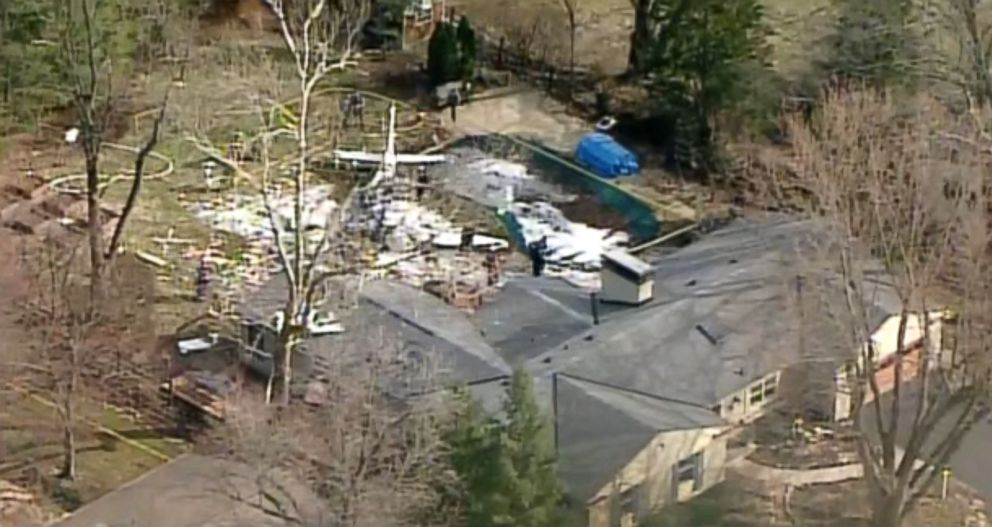

Image for label bicycle accident(1):
Filename: /content/drive/My Drive/Incidents-subset/bicycle accident/-2019-halfdestroyed-260nw-1358999090.jpg


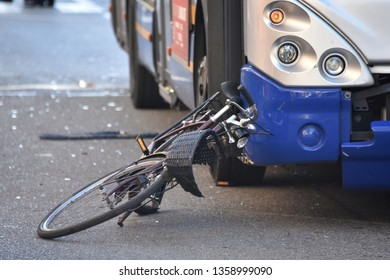

KeyboardInterrupt: ignored

In [ ]:
# Count the number of samples per class
class_counts = {}
image_sizes = []
for i, (image_tensor, label) in enumerate(dataset):
    if label in class_counts:
        class_counts[label] += 1
    else:
        # Print one image per label
        file_name, label = dataset.samples[i]
        import cv2
        from google.colab.patches import cv2_imshow
        print(f"Image for label {classes[label]}({label}):")
        print(f"Filename: {file_name}")
        img = cv2.imread(file_name, cv2.IMREAD_UNCHANGED)
        cv2_imshow(img)

        class_counts[label] = 1

    # Get the size of the image tensor
    size = image_tensor.shape[-2:]

    # Get the number of channels in the image tensor
    if image_tensor.shape[-1] == 1:
        channels = 'L'
    else:
        channels = 'RGB'

    # Add the size and number of channels to the list
    image_sizes.append((size[0], size[1], channels))

# Print the number of samples and classes in the dataset
print(f'Number of samples: {len(dataset)}')
print(f'Number of classes: {len(class_counts)}')

# Print the number of samples per class
print('Samples per class:')
for label, count in class_counts.items():
    print(f'Class {label}: {count}')

# Print the number of samples per class in a table format
print('\nSamples per class (table format):')
print('---------------------------------')
print('| Class | Samples | Percentage |')
print('---------------------------------')
total_samples = len(dataset)
for label, count in class_counts.items():
    percentage = count / total_samples * 100
    print(f'| {label:5d} | {count:7d} | {percentage:9.2f}% |')
print('---------------------------------')

# Calculate and print the minimum, maximum, and average image dimensions
min_width, min_height, min_channels = min(image_sizes)
max_width, max_height, max_channels = max(image_sizes)
avg_width = sum([size[0] for size in image_sizes]) / len(image_sizes)
avg_height = sum([size[1] for size in image_sizes]) / len(image_sizes)
avg_channels = sum([1 if size[2] == 'L' else 3 for size in image_sizes]) / len(image_sizes)

print('Image dimensions:')
print(f'Minimum width: {min_width}')
print(f'Minimum height: {min_height}')
print(f'Minimum channels: {min_channels}')
print(f'Maximum width: {max_width}')
print(f'Maximum height: {max_height}')
print(f'Maximum channels: {max_channels}')
print(f'Average width: {avg_width:.2f}')
print(f'Average height: {avg_height:.2f}')
print(f'Average channels: {avg_channels:.2f}')

The first approach we adopt in order to classify our images is the popular k-NN

# **K-nearest neighbors**

A straightforward, non-parametric machine learning approach called K-nearest neighbors is employed for both classification and regression. K-fundamental NN's premise is to forecast a new data point's label based on the labels of its k closest neighbors in the training set.

The k-NN technique first determines the distances between each new data point and every other point in the training set before making a prediction for a new data point. The new point is then given the label that is most prevalent among its k closest neighbors after being chosen from the k points with the least distances.

A hyperparameter that may be adjusted to improve the algorithm's performance is the value of k. The algorithm will be more sensitive to regional changes in the data if k is set to a lower value, but there is a chance that it will become overfitted. A higher number of k will strengthen the algorithm's resistance to data noise, but it may also result in underfitting.


The k-NN algorithm's readability and simplicity are two benefits. It is simple to comprehend how the algorithm uses the separations between data points to produce predictions. Moreover, k-NN is a great tool for examining complex and nonlinear interactions because it does not demand assumptions about the data's underlying distribution.

The k-NN approach, however, can be computationally expensive as well, particularly when dealing with huge datasets. Furthermore, the choice of distance measure and the existence of redundant or irrelevant information in the data may affect how well the algorithm performs

In [ ]:
# Define a range of k values to try
k_values = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

for k in k_values:
    print(f"Trying k={k}...")
    # Creating a k-NN model
    knn_model = KNeighborsClassifier(n_neighbors=k)

    # Extract the features and labels for the training set
    train_features = []
    train_labels = []
    for batch in train_loader:
        features, labels = batch
        features = features.numpy().reshape(len(features), -1)
        labels = labels.numpy()
        train_features.append(features)
        train_labels.append(labels)
    train_features = np.concatenate(train_features)
    train_labels = np.concatenate(train_labels)

    # Extract the features and labels for the test set
    test_features = []
    test_labels = []
    for batch in test_loader:
        features, labels = batch
        features = features.numpy().reshape(len(features), -1)
        labels = labels.numpy()
        test_features.append(features)
        test_labels.append(labels)
    test_features = np.concatenate(test_features)
    test_labels = np.concatenate(test_labels)

    knn_model.fit(train_features, train_labels)

    # Make predictions on the test set
    y_pred = knn_model.predict(test_features)

    # Compute the evaluation metrics
    accuracy = accuracy_score(test_labels, y_pred)
    precision = precision_score(test_labels, y_pred, average='weighted')
    recall = recall_score(test_labels, y_pred, average='weighted')
    f1 = f1_score(test_labels, y_pred, average='weighted')

    # Print the evaluation metrics
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 score:', f1)

   

    # Compute the accuracy of the model
    accuracy = knn_model.score(test_features, test_labels)

    # Print the accuracy gained
    print(f'Accuracy for k={k}: {accuracy}')


Trying k=1...
Accuracy: 0.23628691983122363
Precision: 0.2567210859484379
Recall: 0.23628691983122363
F1 score: 0.21090408294174068
Accuracy for k=1: 0.23628691983122363
Trying k=5...
Accuracy: 0.2721518987341772
Precision: 0.3013725430498358
Recall: 0.2721518987341772
F1 score: 0.24917697298169028
Accuracy for k=5: 0.2721518987341772
Trying k=10...
Accuracy: 0.2848101265822785
Precision: 0.2931718413327295
Recall: 0.2848101265822785
F1 score: 0.2479714426785701
Accuracy for k=10: 0.2848101265822785
Trying k=15...
Accuracy: 0.3059071729957806
Precision: 0.275618611047849
Recall: 0.3059071729957806
F1 score: 0.26233031078871016
Accuracy for k=15: 0.3059071729957806
Trying k=20...
Accuracy: 0.2890295358649789
Precision: 0.2457785362723737
Recall: 0.2890295358649789
F1 score: 0.24363333523464992
Accuracy for k=20: 0.2890295358649789
Trying k=25...
Accuracy: 0.2869198312236287
Precision: 0.24166501766712736
Recall: 0.2869198312236287
F1 score: 0.240783188438768
Accuracy for k=25: 0.2869198

# **Deep learning approach**

In the quest to achieve high performance in classification tasks, it is not uncommon to encounter situations where traditional machine learning algorithms such as k-Nearest Neighbors (k-NN) may not yield satisfactory results. In such cases, deep learning has emerged as a popular alternative due to its ability to automatically extract relevant features from raw data, leading to improved accuracy in classification tasks.

We would then use a validation dataset to evaluate the performance of the different frameworks and identify the best performing one. The winning framework would then be further evaluated on a test dataset to ensure that it performs well in real-world scenarios.

This process of creating and evaluating multiple deep learning frameworks can be time-consuming and resource-intensive, but it can yield significant performance improvements in classification tasks. Additionally, it can lead to a better understanding of the dataset, as we can investigate which features the deep learning models are learning and what patterns they are capturing.

Overall, the decision to switch from traditional machine learning algorithms to deep learning can be a wise choice in situations where performance is not satisfactory

# **Neural Network frameworks**

## **ResNet18 from the scratch**

The first framework used for the purpose of image classification is ResNet 18, here implemented from the scratch.

ResNet18 is a convolutional neural network architecture part of the ResNet family of models, which was designed to overcome the problem of vanishing gradients in very deep neural networks. The vanishing gradient problem occurs when gradients become very small during backpropagation, making it difficult to train deep neural networks.

ResNet18 is made up of 18 layers, including several residual blocks. Residual blocks are a key feature of the ResNet architecture and are designed to enable the efficient training of very deep neural networks. In a residual block, the input to a layer is added to the output of the layer after passing through one or more convolutional layers. This so-called skip connection enables the network to learn residual functions, which can be easier to optimize than the original functions.

The techniques of Droupout as well as L2-normalization and batch normalization are added as regularization techniques in order to prevent the overfitting of the model

In [ ]:
class ResidualBlock(nn.Module):
    
    def __init__(self, inchannel, outchannel, stride=1):
    
        super(ResidualBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(outchannel)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(outchannel)

        # Shortcut connection to add to output
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):

        # First convolutional layer
        out = F.relu(self.bn1(self.conv1(x)))

        # Second convolutional layer
        out = self.bn2(self.conv2(out))

        # Shortcut connection
        out = out + self.shortcut(x)

        # ReLU activation
        out = F.relu(out)

        return out


class ResNet(nn.Module):
    
    def __init__(self, ResidualBlock, num_classes=12):
        super(ResNet, self).__init__()
    
        self.inchannel = 6
      
        self.conv1 = nn.Sequential(
            # define first convolution layer
            
            nn.Conv2d(3, 6, kernel_size=(2, 2), stride=1, padding=1, bias=False),
            nn.BatchNorm2d(6),
            nn.ReLU()
        )

        # define the first residual block layer
        self.layer1 = self.make_layer(ResidualBlock, 32, 2, stride=1)  

        # define the second residual block layer
        self.layer2 = self.make_layer(ResidualBlock, 64, 2, stride=2)  

        # define the third residual block layer
        self.layer3 = self.make_layer(ResidualBlock, 128, 2, stride=2)  

        # define the fourth residual block layer
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)

        # define global average pooling layer
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # define the fully connected layer
        self.fc = nn.Linear(512, num_classes)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)

        
    def make_layer(self, block, channels, num_blocks, stride):
      
        strides = [stride] + [1] * (num_blocks - 1)
      
        layers = []
      
        for stride in strides:
      
            # create a residual block layer and append it to layers
            layers.append(block(self.inchannel, channels, stride))  
            self.inchannel = channels
      
        # create a sequential layer using the created residual blocks
        return nn.Sequential(*layers)  
    
    def forward(self, x):
      
        # pass the input through the first convolution layer
        out = self.conv1(x)  
        
        # pass the input through the first residual block layer
        out = self.layer1(out) 
        
        # pass the input through the second residual block layer
        out = self.layer2(out)  
        
        # pass the input through the third residual block layer
        out = self.layer3(out)  
        
        # pass the input through the fourth residual block layer
        out = self.layer4(out)  
        
        # perform global average pooling on the output of the last residual block layer
        out = self.global_avg_pool(out)
        
        # flatten the output tensor
        out = out.view(out.size(0), -1)
        
        # L2 normalization
        out = F.normalize(out, p=2, dim=1, eps=1e-12)
        
        # Dropout
        out = self.dropout(out)
        
        # pass the output tensor through the fully connected layer
        out = self.fc(out)
        return out

def ResNet18():
  return ResNet(ResidualBlock)

## **Transfer Learning for Resnet, Alexnet, VGG, Squeezenet, and Densenet**

In the following code cell, we aim to evaluate different frameworks that have been imported directly from the PyTorch library, namely AlexNet, VGG, SqueezeNet, and Densenet.

AlexNet is a deep convolutional neural network architecture that was proposed in 2012 by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton. This architecture has a total of 8 layers, including 5 convolutional layers, 2 fully connected layers, and 1 softmax layer. Some of its most noteworthy features are:

*   The rectified linear unit (ReLU) activation function is utilized, which enhances training time and reduces the risk of the vanishing gradient problem.
*   The architecture introduced the concept of overlapping pooling, which implies that the pooling regions of adjacent pooling layers overlap instead of being disjoint.
*   Local response normalization (LRN) is also included in the architecture, which aids in normalizing the response of adjacent neurons and enhances the model's generalization.
*   AlexNet was trained on the ImageNet dataset, which comprises millions of labeled images across 1,000 different categories.


VGG (Visual Geometry Group) is a convolutional neural network architecture proposed in 2014 by Karen Simonyan and Andrew Zisserman from the University of Oxford. VGG is renowned for its simplicity and effectiveness in deep learning for computer vision tasks. Some key features of VGG are:

*   VGG consists of a total of 19 layers, including 16 convolutional layers and 3 fully connected layers.
*   The convolutional layers in VGG are formed by 3x3 filters, which are stacked on top of each other to create deeper representations.
*   The pooling layers in VGG use max pooling with a 2x2 filter size and a stride of 2.
*   VGG employs the rectified linear unit (ReLU) activation function, which improves training time and reduces the risk of the vanishing gradient problem.
*   Like AlexNet, VGG was trained on the ImageNet dataset.


SqueezeNet is a convolutional neural network architecture introduced in 2016 by Forrest N. Iandola, Song Han, Matthew W. Moskewicz, Khalid Ashraf, William J. Dally, and Kurt Keutzer from the University of California, Berkeley. SqueezeNet is renowned for its small size, which makes it ideal for resource-constrained environments like mobile devices and embedded systems. Here are some key features of SqueezeNet:

*   SqueezeNet is a small network with a total of only 23 layers, which is significantly smaller than other popular architectures such as AlexNet and VGG.
*   It achieves its small size by employing a combination of 1x1 convolutional filters and a technique called "fire modules," which are designed to balance the number of filters and the computational cost.
*   SqueezeNet also uses a technique called "deep compression," which further reduces the size of the network by applying pruning and quantization techniques. Despite its small size, SqueezeNet achieves competitive accuracy on the ImageNet dataset.

The following function is to use the pre-trained model only to extract image features. This can be useful to save computational time and resources, as there is no need to calculate gradients and update model weights.

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    
    """
    A function that sets the requires_grad attribute of model parameters
    to False if feature_extracting is True, and to True otherwise.

    Args:
    - model: a PyTorch model
    - feature_extracting: a boolean value that indicates whether we want
      to extract features from the model (True) or fine-tune the model (False)

    Returns:
    - None
    """

    # If we're only extracting features, we don't want to update the model parameters
    if feature_extracting:
        # Loop over all parameters in the model and set their requires_grad attribute to False
        for param in model.parameters():
            param.requires_grad = False

## **Set the model**

Here below we can choose which one between the neural networks architectures previously mentioned we want to test, just changing the parameter "model_name"

In [ ]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet]
model_name = "alexnet"

# Number of classes in the dataset
num_classes = 12

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

def initialize_model(model_name, num_classes, feature_extract, use_pretrained):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == "ResNet18":
        model_ft = ResNet18()
        input_size = 224
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)

# Print the model we just instantiated
print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

This function is used to define which model parameters will be updated during training, based on the choice of "feature extract" and the finetuning request.

Specifically, the function retrieves all the model parameters "model_ft" and assigns them to the variable "params_to_update". If "feature_extract" is set to True, then the function extracts only those parameters that have the "requires_grad" attribute set to True and adds them to the "params_to_update" list. These will be the only parameters that will be updated during training. On the other hand, if "feature_extract" is set to False, all the parameters in the model will have the "requires_grad" attribute set to True and will be updated during training.

Finally, the function prints the names of the parameters that will be updated during training (if "feature_extract" is False) or that have been selected for update (if "feature_extract" is True). This information can be useful for verifying that model parameters are updated correctly during training and for monitoring the training process.

In [ ]:
# Gather the parameters to be optimized/updated in this run. If we are finetuning we will be updating all parameters. However, if we are doing 
# feature extract method, we will only update the parameters that we have just initialized, i.e. the parameters with requires_grad is True

def update_params_to_learn(model_ft, feature_extract):
    
    """
    A function that determines which parameters of a PyTorch model should be
    updated during training, based on whether we want to fine-tune the model
    (feature_extract = False) or extract features (feature_extract = True).

    Args:
    - model_ft: a PyTorch model
    - feature_extract: a boolean value that indicates whether we want to
      extract features from the model (True) or fine-tune the model (False)

    Returns:
    - params_to_update: a list of parameters to be updated during training
    """

    # Get all parameters of the model
    params_to_update = model_ft.parameters()

    # If we're only extracting features, we only want to update certain parameters
    if feature_extract:
        # Create an empty list to store the parameters we want to update
        params_to_update = []
        # Loop over all named parameters in the model and check if requires_grad is True
        for name, param in model_ft.named_parameters():
            if param.requires_grad == True:
                # If the parameter should be updated, append it to the list
                params_to_update.append(param)
                print("\t", name)
    # If we're fine-tuning the model, update all parameters with requires_grad=True
    else:
        for name, param in model_ft.named_parameters():
            if param.requires_grad == True:
                print("\t", name)

    return params_to_update

## **Print a png image of the framework concerned**

In [ ]:
# import the ResNet architecture and the ResidualBlock module
model = model_ft

# create a sample input tensor with shape (1, 3, 224, 224)
x = torch.randn(1, 3, 224, 224)

# pass the input tensor through the model to get the output
y = model(x)

# create a visualization of the computation graph using graphviz
# this helps visualize the flow of information through the model
dot = make_dot(y, params=dict(model.named_parameters()))

# Save the computation graph as an image
dot.render(filename='MyModel', format='png')

'MyModel.png'

## **Instantiate the Neural Network**

Here we decide which loss function (Cross Entropy) to use as well as the optimizer (Stochastic Gradient Descent).



In [ ]:
# Set the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set some parameters
epoch = 50
learning_rate = 0.1
momentum=0.9
weight_decay=5e-4

# Set the model we are going to use
model_ft = model_ft.to(device)

# Loss funtion
cost_function = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model_ft.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

## **Early Stopping**

Early stopping is a technique used to prevent overfitting and it is based on the idea that the model's performance on the validation set will stop improving after a certain number of training epochs, and continuing to train beyond this point will only lead to overfitting.

In this case the monitor is on the perplexity: after three times we see the perplexity increasing we stop the training and get the final value.

There are several benefits to using early stopping:



1.   It can help prevent overfitting by stopping the training process before the model starts to overfit the training data;
2.   It can save time and resources by avoiding the need to train the model for a large number of epochs;
3.   It can improve the generalization ability of the model by avoiding the use of models that are overfitted to the training data.

In [ ]:
class EarlyStopping:
 
  """
    A class for early stopping of training process. 
    
    Args:
        patience (int): Number of epochs to wait before triggering early stopping. Default: 5
        verbose (bool): Flag indicating whether to print messages when early stopping is triggered. Default: True
        
    Attributes:
        patience (int): Number of epochs to wait before triggering early stopping.
        verbose (bool): Flag indicating whether to print messages when early stopping is triggered.
        counter (int): Counter for the number of epochs since the last improvement.
        best_score (float): Best score seen so far. None by default.
  """
  
  def __init__(self, patience=5, verbose=True):
   
    # set the number of epochs to wait before triggering early stopping
    self.patience = patience
   
    # set a flag indicating whether to print messages when early stopping is triggered
    self.verbose = verbose
   
    # initialize the counter for the number of epochs since the last improvement
    self.counter = 0
   
    # initialize the best score seen so far to None
    self.best_score = None

  def step(self, val_loss):
  
    """
        Function to check if early stopping should be triggered.
        
        Args:
            val_loss (float): Current validation loss.
        
        Returns:
            bool: Whether early stopping should be triggered or not.
    """
   
    # if this is the first epoch, set the best score to the current validation loss
    if self.best_score is None:
   
      self.best_score = val_loss
   
    # if the current validation loss is worse than the best score seen so far
    elif val_loss > self.best_score:
   
      # increment the counter
      self.counter += 1
   
      # if the counter has reached the patience threshold
      if self.counter >= self.patience:
   
        # if verbose is True, print a message indicating that early stopping has been triggered
        if self.verbose:
   
          print(f'Early stopping triggered with counter {self.counter} and patience {self.patience}')
   
        # return True to indicate that early stopping should be triggered
        return True
   
    # if the current validation loss is better than the best score seen so far
   
    else:
   
      # set the best score to the current validation loss
      self.best_score = val_loss
   
      # reset the counter
      self.counter = 0
   
    # if the counter has not reached the patience threshold, return False
    return False

## **Training Step**

The training_step function is a Python function that represents a training step (training step) of a neural network. The function takes as input a neural network (net), a training set (train_loader), a validation set (valid_loader), an optimizer (optimizer), a cost function (cost_function), and a device (device) on which to run the training (by default "cuda," indicating an NVIDIA GPU).

The function under consideration is responsible for training and validating a neural network. To begin with, the function sets the network to training mode by calling the net.train() function. The training cycle is then initiated on the training set using a for loop that iterates over the batches of inputs and targets in the train_loader. For each batch, the function performs the following steps:

Firstly, the input image is resized to a specific size. Then, both inputs and targets are moved to the specified device (device). The gradients of the optimizer are then zeroed using the optimizer.zero_grad() function. Next, a forward pass is performed on the neural network, where the outputs are computed by passing the inputs through the network (outputs = net(inputs)). The cost function is then calculated by comparing the outputs with the corresponding targets (loss = cost_function(outputs, targets)). Subsequently, the backward pass is computed to calculate the gradients using loss.backward(). Finally, the optimizer is updated by taking a step in the opposite direction of the gradients using the optimizer.step() function. Additionally, the function calculates the training accuracy (train_acc) and tracks the training loss (train_loss).

Upon completing the training cycle on the training set, the function proceeds to the validation cycle on the validation set. A for loop is used to iterate over the batches of inputs and targets in the valid_loader. For each batch, the function repeats steps 1 to 5 and computes the validation accuracy (valid_acc) and tracks the validation loss (valid_loss).

At the end of the function, the average training loss (train_loss), average training accuracy (train_acc), average validation loss (valid_loss), and average validation accuracy (valid_acc) are returned as a tuple. These values are useful for monitoring and evaluating the performance of the neural network during training.

In [ ]:
def training_step(net, train_loader, valid_loader, optimizer, cost_function, device='cuda'):

    # set the network to training mode
    net.train()

    # train loop
    train_loss = 0.0
    train_acc = 0.0
    num_train_samples = 0

    # iterate over training data
    for inputs, targets in train_loader:

        # resize the inputs
        inputs = Resize((224, 224))(inputs)

        # move inputs and targets to specified device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # zero the optimizer gradients
        optimizer.zero_grad()

        # forward pass
        outputs = net(inputs)

        # compute the loss
        loss = cost_function(outputs, targets)

        # backward pass
        loss.backward()

        # update model parameters
        optimizer.step()

        # compute training accuracy
        _, predicted = outputs.max(1)
        num_train_samples += targets.size(0)
        train_acc += predicted.eq(targets).sum().item()

        # track training loss
        train_loss += loss.item()

    # compute average training loss and accuracy
    train_loss /= len(train_loader)
    train_acc /= num_train_samples

    # Validation loop
    net.eval()
    valid_loss = 0.0
    valid_acc = 0.0
    num_valid_samples = 0

    # iterate over validation data
    with torch.no_grad():
        for inputs, targets in valid_loader:

            # resize the inputs
            inputs = Resize((224, 224))(inputs)

            # move inputs and targets to specified
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = net(inputs)
            loss = cost_function(outputs, targets)

            # Compute validation accuracy
            _, predicted = outputs.max(1)
            num_valid_samples += targets.size(0)
            valid_acc += predicted.eq(targets).sum().item()

            valid_loss += loss.item()

    # calculate average validation loss and accuracy
    valid_loss /= len(valid_loader)
    valid_acc /= num_valid_samples

    return train_loss, train_acc, valid_loss, valid_acc

## **Test Step**

The Python function test_step is an important tool for evaluating the performance of a neural network during the validation or testing phase. The function takes as input the neural network (net), a data loader (data_loader), a cost function (cost_function), and a device (device) on which to run the test.

The function begins by setting the neural network to evaluation mode (net.eval()). Next, the function iterates through the data loader, which contains the test data set, using a for loop. For each batch of inputs and targets in the data loader, the function performs a series of steps.

First, the function moves the inputs and targets to the specified device (device). Then, the function performs a forward pass of the neural network to generate the outputs (outputs = net(inputs)). The function then calculates the cost function (loss = cost_function(outputs, targets)).

The evaluation metrics are then updated, which include calculating the total accuracy (total_acc) by adding the total number of samples in the batch (targets.size(0)) to the variable total_acc, and calculating the correct accuracy (correct_acc) by adding the number of correct predictions ((predicted == targets).sum().item()) to the correct_acc variable. The function also calculates the total loss (loss_acc) by summing the batch loss (loss.item()) multiplied by the total number of batch samples (targets.size(0)) to the variable loss_acc.

At the end of the function, the average test loss (loss_acc / total_acc) and average test accuracy (correct_acc / total_acc) are returned as a tuple. These values can be used to evaluate the performance of the neural network on the test data. Overall, the test_step function is an essential tool for assessing the accuracy and effectiveness of a neural network, enabling users to make informed decisions regarding model optimization and refinement.

In [ ]:
def test_step(net, data_loader, cost_function, device):
  net.eval()
  loss_acc = 0
  correct_acc = 0
  total_acc = 0

  with torch.no_grad():
    for inputs, targets in data_loader:
      
      # load data into GPU
      inputs = inputs.to(device)
      targets = targets.to(device)

      # forward pass
      outputs = net(inputs)
      loss = cost_function(outputs, targets)

      # update metrics
      _, predicted = torch.max(outputs.data, 1)
      total_acc += targets.size(0)
      correct_acc += (predicted == targets).sum().item()
      loss_acc += loss.item() * targets.size(0)

  return loss_acc / total_acc, correct_acc / total_acc

The provided code is a Python function called "main" that facilitates an entire iteration of a neural network training process for classification. The function requires training configuration parameters, including the number of epochs, batch size, learning rate, weight decay, momentum, training data loader, validation data loader, test data loader, optimizer, and cost function.

Within the function, an early stopping criterion is established to terminate training when the validation loss does not improve for a specified number of epochs. The function then iterates through the specified number of epochs and calls the training_step function at each iteration to train the network based on the training and validation data loader.

During training, the model parameters with the lowest validation loss up to that point are saved. After training, the function uses the saved model parameters to perform the final testing on the test data.

Finally, the function returns the losses and accuracies for the training, validation, and test data as output. Additionally, the code provides an option to save the trained model to disk for future use.

This code demonstrates the importance of an iterative approach to training a neural network. By breaking the training process into smaller steps, such as training and validation, the model can be evaluated and refined regularly. The use of early stopping prevents the model from overfitting to the training data, and the ability to save the trained model enables it to be used in other contexts or applications.

In [ ]:
def main(batch_size, 
         device, 
         learning_rate, 
         weight_decay, 
         momentum, 
         epochs,
         train_loader,
         valid_loader,
         test_loader,
         optimizer,
         cost_function):

    # Create the early stopping criterion
    criterion = EarlyStopping(patience=5, verbose=True)

    # initialize variables to keep track of best validation loss and corresponding model parameters
    best_loss = float('inf')
    best_params = None

    # iterate over the number of epochs
    for e in range(epochs):

        # train & log
        train_loss, train_acc, valid_loss, valid_acc = training_step(model_ft, train_loader, valid_loader, optimizer, cost_function, device)

        # check if the current validation loss is the best seen so far
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_params = model_ft.state_dict()
            
            '''
            # Save the model
            torch.save({'model_state_dict': model_ft.state_dict()},"/content/drive/MyDrive/"+ model_name + "_{:.3f}".format(best_loss))

            print("Model saved at BaseModel_{:.3f}".format(best_loss))
            '''
            
        # check if early stopping should be triggered
        if criterion.step(valid_loss):
            print('Early stopping triggered')
            break

        ltrain_loss.append(train_loss)
        lvalid_loss.append(valid_loss)

        # log epoch results
        print(f'Epoch {e+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.4f}')

    # load the best model parameters
    model_ft.load_state_dict(best_params)
 
    # test the model on the test set
    test_loss, test_acc = test_step(model_ft, test_loader, cost_function, device)


    # Save the model
    torch.save({'model_state_dict': model_ft.state_dict()},"/content/drive/MyDrive/"+ model_name + "_{:.3f}".format(best_loss))
    print("Model saved at BaseModel_{:.3f}".format(best_loss))


    # log test results
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    return (train_loss,train_acc,valid_loss,valid_acc,test_loss,test_acc)

## **Launch everything**

In [ ]:
ltrain_loss = []
lvalid_loss = []
train_loss,train_acc,valid_loss,valid_acc,test_loss,test_acc=main(batch_size, device, learning_rate, weight_decay, momentum, epoch, train_loader, valid_loader, test_loader, optimizer, cost_function)

KeyboardInterrupt: ignored

In [ ]:
# Initialize the model for this run

model_name = "squeezenet"
best_loss = 0.930

path = f"/content/drive/MyDrive/"+ model_name + "_{:.3f}".format(best_loss)

test_model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

test_model.load_state_dict(torch.load(path)["model_state_dict"])

test_model = test_model.to(device)

print(test_model)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 24.7MB/s]


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

### **Plot the train and validation loss**

In [ ]:
# Set the number of epochs
epochs = range(1,len(lvalid_loss)+1)

# Create a new figure with white background and set its title and axis labels
plt.figure(num=3, figsize=(8, 5)).patch.set_facecolor('pink')
plt.title('Regolarized: Train and Valid Losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')

# Plot the train loss and valid loss for the given number of epochs
plt.plot(epochs, ltrain_loss, color='blue', label='Train loss')
plt.plot(epochs, lvalid_loss, color='orange', label='Valid loss')


# Add a legend to the plot and display it
plt.legend()
plt.show()

Here we reload the saved models in order to avoid to train the frameworks everytime

In [ ]:
test_model = torch.load('/content/drive/MyDrive/CIRI_2.239', map_location=torch.device('cpu'))

#test_model, input_size = initialize_model(model, num_classes, feature_extract, use_pretrained=True)
#test_model.load_state_dict(torch.load(path, map_location=device))

## **Accuracies**

### **Get the predictions from the trained model**

This function takes as input the neural network model, the data loader (data_loader) which provides the input data to the model, and the device to run the computation on. It returns the predicted class labels and true class labels as two lists (y_pred and y_true, respectively).

Incorrect image: /content/drive/My Drive/Incidents-subset/flooded/3000_post_oak_nw_entrance-2_harvey.jpg
Predicted label: volcanic eruption(10), actual label: flooded(5)


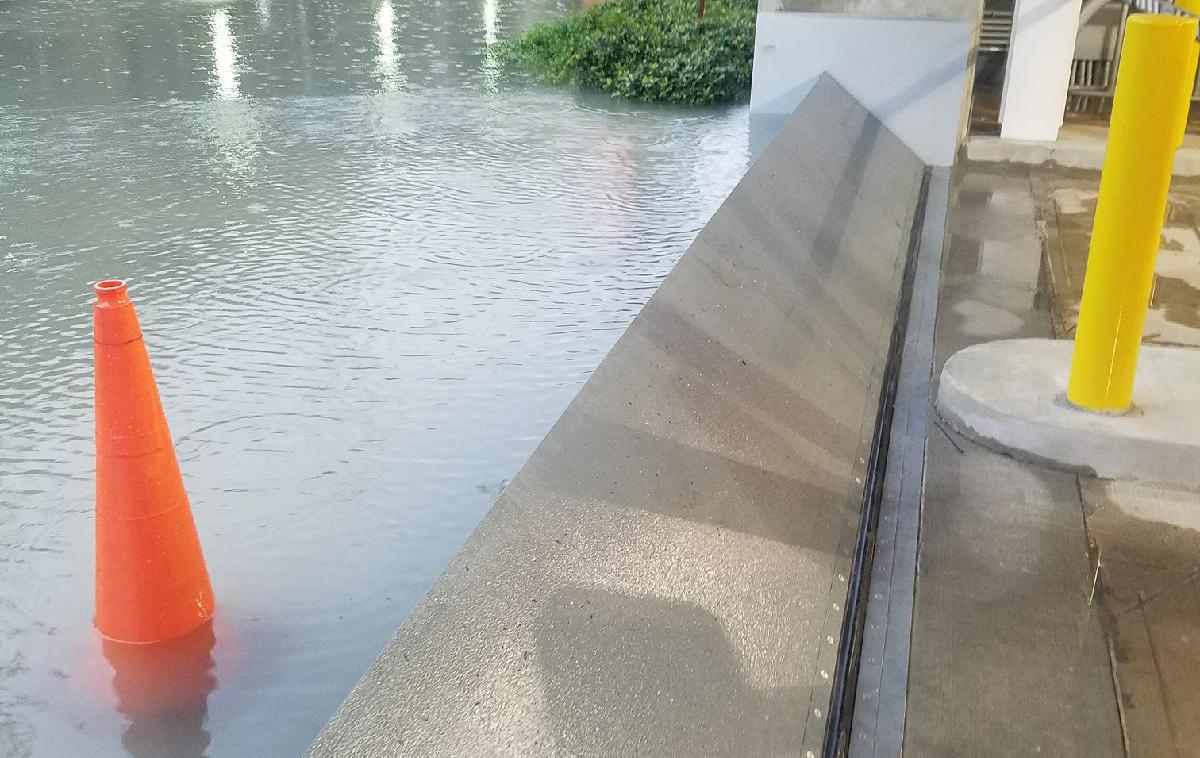

Correct image: /content/drive/My Drive/Incidents-subset/volcanic eruption/370534.jpg
Predicted label: volcanic eruption(10), actual label: volcanic eruption(10)


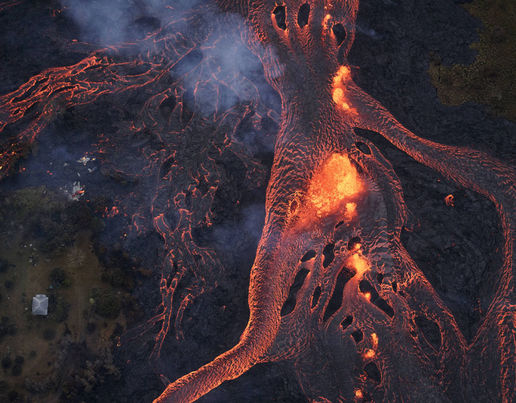

In [ ]:
def predict(net, data_loader, device='cuda'):
    
    # set the network to evaluation mode
    net.eval()
    
    # initialize empty lists to store predicted and true labels
    y_pred = []
    y_true = []
    features = []

    correct_printed = False
    incorrect_printed = False

    # disable gradient computation (we are only predicting, we do not want our model to be modified in this step!)
    with torch.no_grad():
    
        # iterate over the data loader
        for batch_idx, (inputs, targets) in enumerate(data_loader):
    
            # load data into GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass
            outputs = net(inputs)
            #outputs, feats = net(inputs, return_feats=True)

            # retrieve the predicted class labels
            _, predicted = outputs.max(dim=1)

            # append predicted and true labels to their corresponding lists
            y_pred += predicted.cpu().numpy().tolist()
            y_true += targets.cpu().numpy().tolist()
            # features.append(feats.cpu().numpy())


            # Print sample images which are correctly and incorrectly classified, along with their paths
            # invTrans = transforms.Compose([transforms.Normalize(mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5], std=[1/0.5, 1/0.5, 1/0.5])])
            for i, pred in enumerate(y_pred):
              if pred == y_true[i] and not correct_printed:

                # Find the file name
                index = data_loader.dataset.indices[i]
                file_name, label = dataset.samples[index]

                # Show the image
                print(f"Correct image: {file_name}")
                print(f"Predicted label: {classes[pred]}({pred}), actual label: {classes[y_true[i]]}({y_true[i]})")
                import cv2
                from google.colab.patches import cv2_imshow
                img = cv2.imread(file_name, cv2.IMREAD_UNCHANGED)
                cv2_imshow(img)

                correct_printed = True
              elif pred != y_true[i] and not incorrect_printed:

                # Find the file name
                index = data_loader.dataset.indices[i]
                file_name, label = dataset.samples[index]

                # Show the image
                print(f"Incorrect image: {file_name}")
                print(f"Predicted label: {classes[pred]}({pred}), actual label: {classes[y_true[i]]}({y_true[i]})")
                import cv2
                from google.colab.patches import cv2_imshow
                img = cv2.imread(file_name, cv2.IMREAD_UNCHANGED)
                cv2_imshow(img)

                incorrect_printed = True
 
            
    # return the predicted and true labels as lists
    return y_pred, y_true

y_true, y_pred = predict(test_model, test_loader, device="cpu")

In [ ]:
from keras.utils import to_categorical

y_pred = to_categorical(y_pred, num_classes=12)
y_true = to_categorical(y_true, num_classes=12)

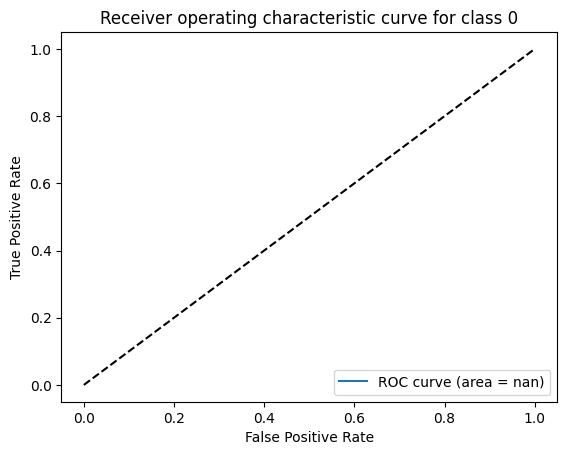

In [ ]:
from sklearn.preprocessing import label_binarize

# assuming y_true and y_pred are the true and predicted labels, respectively
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# binarize the multiclass labels
y_true = label_binarize(y_true, classes=np.arange(12))

# calculate fpr, tpr and thresholds for class 0
fpr, tpr, thresholds = roc_curve(y_true[:, 0], y_pred[:, 0])

# calculate area under curve for class 0
roc_auc = auc(fpr, tpr)

# plot ROC curve for class 0
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve for class 0')
plt.legend(loc="lower right")
plt.show()

### **Confusion Matrix**

A confusion matrix is a table that is used to evaluate the performance of a classification model. It is a way to visualize the number of true positives, false positives, true negatives, and false negatives that are produced by a model's predictions.

The confusion matrix has two dimensions: the actual values and the predicted values. The actual values are the true labels of the data, while the predicted values are the labels that the model has assigned to the data.

The four components of the confusion matrix are:
*   True positives (TP): The number of positive instances that were correctly classified as positive by the model;
*   False positives (FP): The number of negative instances that were incorrectly classified as positive by the model
*   True negatives (TN): The number of negative instances that were correctly classified as negative by the model;
*   False negatives (FN): The number of positive instances that were incorrectly classified as negative by the model.


The confusion matrix provides a way to evaluate how well a classification model is performing, and it is often used to calculate other evaluation metrics such as accuracy, precision, recall, and F1-score. By examining the confusion matrix, you can get a better understanding of the strengths and weaknesses of your model and adjust it accordingly.

In [ ]:
def confusion_matrix(y_true, y_pred, num_classes):
    
    # Create an empty confusion matrix with num_classes rows and columns
    conf_mat = np.zeros((num_classes, num_classes))
    
    # Loop over each example in the dataset
    for i in range(len(y_true)):
        
        # Get the true class and predicted class for the current example
        true_class = int(y_true[i])
        pred_class = int(y_pred[i])
        
        # Increment the corresponding entry in the confusion matrix
        conf_mat[true_class, pred_class] += 1
    
    # Return the resulting confusion matrix
    return conf_mat

Let's plot here the confusion matrix we have computed above

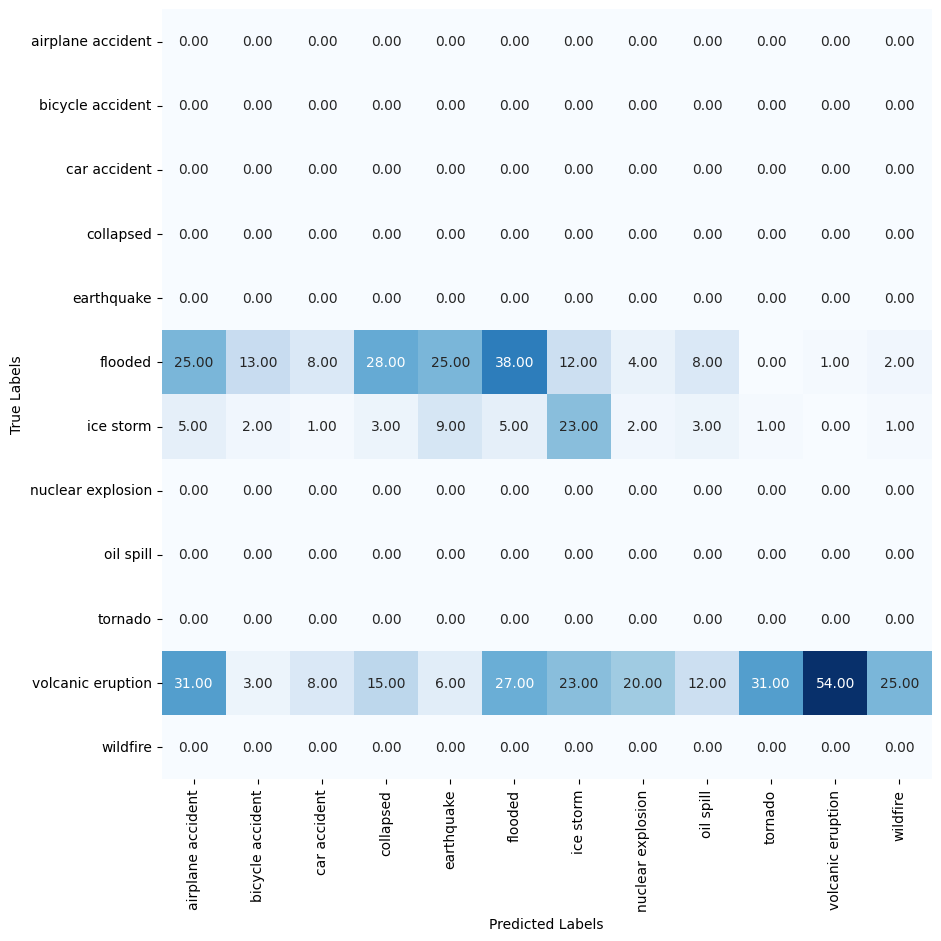

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes):
    # Compute confusion matrix
    num_classes=len(classes)
    conf_mat = confusion_matrix(y_true, y_pred, num_classes)
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(conf_mat, annot=True, fmt='.2f', cmap='Blues', square=True, cbar=False, ax=ax)
    
    # Set labels and ticks
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(classes, rotation=90)
    ax.set_yticklabels(classes, rotation=0)
    
    plt.show()


plot_confusion_matrix(y_true, y_pred, classes)

### **Calculate accuracy**

Accuracy is a common evaluation metric for classification models that measures the proportion of correct predictions among all predictions made by the model. In this function, the accuracy is calculated by dividing the number of correct predictions by the total number of examples.

The correct variable in the function keeps track of the number of examples for which the predicted label matches the true label. The total variable keeps track of the total number of examples.

In [ ]:
def calculate_accuracy(model, dataloader, device):
    
    # Put the model in evaluation mode
    model.eval()
    
    # Initialize variables to keep track of the number of correct predictions and total examples
    correct = 0
    total = 0
    
    # Use torch.no_grad() to disable gradient calculation during evaluation
    with torch.no_grad():
        
        # Loop over each batch of data in the dataloader
        for data in dataloader:
            
            # Move the input data and labels to the specified device
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # Make predictions using the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, dim=1)
            
            # Update the total count of examples and number of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Calculate the accuracy by dividing the number of correct predictions by the total number of examples
    accuracy = correct / total
    
    # Return the accuracy
    return accuracy

Let's print the results

In [ ]:
accuracy = calculate_accuracy(test_model, test_loader, "cpu")
print("Accuracy:", accuracy)

Accuracy: 0.16033755274261605


### **Weighted Accuracy**

Weighted accuracy is a metric for classification models that measures the average accuracy weighted by the number of samples in each class. The idea behind this metric is to give higher weight to the accuracy of classes with more samples, as misclassifying a sample in a larger class has a greater impact on the overall accuracy of the model than misclassifying a sample in a smaller class

In [ ]:
def calculate_weighted_accuracy(model, data_loader, num_classes):
    
    # Get the device the model is running on
    device = next(model.parameters()).device
    
    # Initialize lists to keep track of correct and total predictions for each class
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes
    
    # Disable gradient computation for evaluation
    with torch.no_grad():
        
        # Loop over each batch of data in the data loader
        for data in data_loader:
            
            # Move the input data and labels to the specified device
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Make predictions using the model
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Update the number of correct and total predictions for each class
            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                label = labels[i]

                try:  # Tensor.squeeze() could squeeze in such a way that tensor only has one item instead of a list, so c[i] won't work
                  class_correct[label] += c[i].item()
                except Exception:
                  class_correct[label] += c.item()

                class_total[label] += 1

    # Calculate the weight of each class as its proportion of the total number of examples
    class_weight = [class_total[i] / sum(class_total) for i in range(num_classes)]
    
    # Calculate the weighted accuracy as the weighted average of accuracy for each class
    weighted_accuracy = sum([class_weight[i] * class_correct[i] / class_total[i] for i in range(num_classes)])
    
    # Return the weighted accuracy
    return weighted_accuracy

Let's print the results

In [ ]:
weighted_accuracy = calculate_weighted_accuracy(test_model, test_loader,12)
print("Weighted accuracy:", weighted_accuracy)

Weighted accuracy: 0.16033755274261605


### **Precision**

Precision is a common performance metric used in machine learning and statistics to evaluate the accuracy of a model or classifier.

Precision is the fraction of true positive predictions out of all positive predictions made by the model. In other words, precision measures how many of the positive predictions made by the model are actually correct.

Here's the formula for precision:

Precision = true positives / (true positives + false positives)

Where:

*  True positives (TP) are the number of correct positive predictions made by the model;
*  False positives (FP) are the number of incorrect positive predictions made by the model

In [ ]:
def calculate_precision(model, data_loader):
    # Set the model to evaluation mode
    model.eval()
    # Initialize lists to store the predicted and true labels
    predictions = []
    targets = []
    # Iterate through the data loader
    with torch.no_grad():
        for images, labels in data_loader:
            # Move the data to the device
            images = images.to(device)
            labels = labels.to(device)
            # Forward pass through the model
            outputs = model(images)
            # Get the predicted class labels
            _, predicted = torch.max(outputs.data, 1)
            # Move the predicted labels to the CPU
            predicted = predicted.to('cpu')
            # Append the true and predicted labels to the lists
            targets.append(labels.to('cpu'))
            predictions.append(predicted)
    # Concatenate the predicted and true labels into tensors
    predictions = torch.cat(predictions)
    targets = torch.cat(targets)
    # Compute the weighted average precision score
    precision = precision_score(targets, predictions, average='weighted')
    return precision

Let's print the results

In [ ]:
precision = calculate_precision(model_ft, test_loader)
print("Precision:", precision)

Precision: 0.02570813081949118


### **Recall**

Recall is a common metric used in machine learning to evaluate the performance of a binary classifier. It measures the proportion of true positive predictions made by the model out of all actual positive instances in the dataset.

Recall is calculated as the ratio of the number of true positive predictions to the sum of true positive and false negative predictions. In other words:

$Recall = True Positives / (True Positives + False Negatives)$

A high recall score indicates that the model is good at correctly identifying all instances of the positive class, but it may also result in a higher number of false positive predictions. On the other hand, a low recall score indicates that the model is not good at correctly identifying positive instances, which can be problematic if the positive class is of high importance

In [ ]:
def calculate_recall(model, data_loader):
    
    """
    Calculates the recall score of a PyTorch model on a dataset.

    Args:
        model (nn.Module): The PyTorch model to evaluate.
        data_loader (DataLoader): A PyTorch DataLoader object containing the evaluation dataset.

    Returns:
        float: The weighted recall score of the model on the dataset.
    """

    # Switch the model to evaluation mode
    model.eval()

    # Create empty lists to store the true and predicted labels
    y_true = []
    y_pred = []

    # Disable gradient calculations to save memory
    with torch.no_grad():

        # Iterate over the evaluation dataset
        for inputs, labels in data_loader:

            # Move the inputs and labels to the appropriate device (e.g., GPU)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Make predictions with the model
            outputs = model(inputs)

            # Get the predicted labels as the class with the highest output score
            _, predicted = torch.max(outputs, dim=1)

            # Append the true and predicted labels to the lists
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate the recall score using scikit-learn's recall_score function
    return recall_score(y_true, y_pred, average='weighted')

Let's print the results

In [ ]:
recall = calculate_recall(model_ft, test_loader)
print("Recall:", recall)

Recall: 0.16033755274261605


### **F1 Score**

The F1 score is a metric commonly used to evaluate the performance of a classification model. It is the harmonic mean of precision and recall, and ranges between 0 and 1, where 1 indicates perfect precision and recall, and 0 indicates that the model has failed to correctly classify any samples.
Precision is the proportion of correctly predicted positive samples out of all the predicted positive samples, while recall is the proportion of correctly predicted positive samples out of all the true positive samples. The F1 score takes into account both precision and recall, and is a good metric to use when the classes are imbalanced, i.e., when some classes have significantly fewer samples than others

In [ ]:
# This function calculates the F1 score of a classification model
# The F1 score is a metric that combines precision and recall
# It is a harmonic mean of precision and recall, and ranges between 0 and 1

def calculate_f1_score(model, data_loader):
    model.eval()
    
    # Initialize empty lists to store true and predicted labels
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            
            # Get the predicted labels by finding the index of the maximum log-probability
            _, predicted = torch.max(outputs, 1)
            
            # Add the true and predicted labels to the respective lists
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    # Compute the F1 score using scikit-learn's f1_score function
    # The 'weighted' option computes the average F1 score weighted by the number of samples in each class
    return f1_score(y_true, y_pred, average='weighted')

Let's print the results

In [ ]:
f1_score=calculate_f1_score(model_ft, test_loader)
print("f1_score:", f1_score)

f1_score: 0.044311469121595705


### **K-fold Cross Validation**

K-fold cross-validation is a popular method used in machine learning to evaluate the performance of a model on a dataset. It involves dividing the dataset into k equally sized subsets, or "folds", and training and testing the model k times. In each iteration, one fold is used as the test set and the remaining k-1 folds are used as the training set.

The process of training and testing the model is repeated k times, with each fold used exactly once as the test set. The results from each iteration are then averaged to obtain a final evaluation score for the model.

K-fold cross-validation is commonly used in machine learning for several reasons:

It allows for a more reliable estimate of the model's performance on unseen data, as all data points are used for both training and testing.
It helps to reduce the risk of overfitting, as the model is trained and evaluated on different subsets of the data.
It allows for a better use of available data, especially in cases where the dataset is small.
One important consideration when using k-fold cross-validation is the choice of k

In [ ]:
# number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

valid_loss = []
valid_acc = []

for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
    print(f'Fold {fold+1}/{k}')
    
    # create data loaders for the current fold
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
    
    # train the model for the current fold
    train_loss, train_acc, val_loss, val_acc = training_step(test_model, train_loader, valid_loader, optimizer, cost_function, device)
    
    # compute and save the validation performance for the current fold
    valid_loss.append(val_loss)
    valid_acc.append(val_acc)

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


In [ ]:
print(valid_loss)
print(valid_acc)

for i in range(k):
  print(f"Fold: {i}")
  print(f"Loss: {valid_loss[i]}")
  print(f"Accuracy: {valid_acc[i]}")

avg_acc = round(sum(valid_acc)/k,5)
std_list= round(np.std(valid_acc),5)
print('Average accuracy: ', avg_acc,'+-', std_list) 

[0.8068595859019653, 0.8068595859019653, 0.8068595859019653, 0.8068595859019653, 0.8068595859019653]
[0.7605442176870748, 0.7605442176870748, 0.7605442176870748, 0.7605442176870748, 0.7605442176870748]
Fold: 0
Loss: 0.8068595859019653
Accuracy: 0.7605442176870748
Fold: 1
Loss: 0.8068595859019653
Accuracy: 0.7605442176870748
Fold: 2
Loss: 0.8068595859019653
Accuracy: 0.7605442176870748
Fold: 3
Loss: 0.8068595859019653
Accuracy: 0.7605442176870748
Fold: 4
Loss: 0.8068595859019653
Accuracy: 0.7605442176870748
Average accuracy:  0.76054 +- 0.0


### **T-SNE**

We define two functions:

*  get_tsne generates the t-SNE regarding the classes of target samples;
*  get_tsne_src_tgt generates the t-SNE regarding the source and target samples.

Both functions take in input the features extracted from the last layer of the network, before the final linear classifier

In [ ]:
def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    # get features from the last layer of the model
    features = np.squeeze(features)
    return features, labels

In [ ]:
features, labels = extract_features(test_model, test_loader, "cpu")
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(features)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 737 samples in 0.008s...
[t-SNE] Computed neighbors for 737 samples in 0.027s...
[t-SNE] Computed conditional probabilities for sample 737 / 737
[t-SNE] Mean sigma: 5.386372
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.073174
[t-SNE] KL divergence after 300 iterations: 1.040866


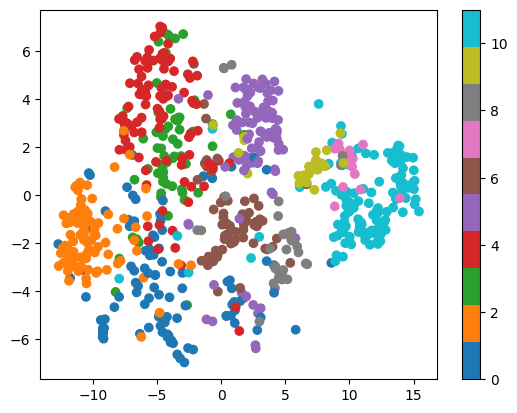

In [ ]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()